[MLP] ep1/1200 train=7.636e+02 val=7.209e+02 vio_tr=2.523e+01 vio_va=2.467e+01
[MLP] ep100/1200 train=7.409e+02 val=6.990e+02 vio_tr=2.463e+01 vio_va=2.408e+01
[MLP] ep200/1200 train=7.155e+02 val=6.745e+02 vio_tr=2.395e+01 vio_va=2.340e+01
[MLP] ep300/1200 train=6.831e+02 val=6.432e+02 vio_tr=2.327e+01 vio_va=2.273e+01
[MLP] ep400/1200 train=6.403e+02 val=6.020e+02 vio_tr=2.365e+01 vio_va=2.308e+01
[MLP] ep500/1200 train=5.859e+02 val=5.496e+02 vio_tr=2.823e+01 vio_va=2.756e+01
[MLP] ep600/1200 train=5.217e+02 val=4.879e+02 vio_tr=3.225e+01 vio_va=3.147e+01
[MLP] ep700/1200 train=4.500e+02 val=4.192e+02 vio_tr=2.946e+01 vio_va=2.871e+01
[MLP] ep800/1200 train=3.746e+02 val=3.472e+02 vio_tr=2.428e+01 vio_va=2.360e+01
[MLP] ep900/1200 train=3.013e+02 val=2.775e+02 vio_tr=1.976e+01 vio_va=1.913e+01
[MLP] ep1000/1200 train=2.351e+02 val=2.151e+02 vio_tr=1.582e+01 vio_va=1.523e+01
[MLP] ep1100/1200 train=1.797e+02 val=1.633e+02 vio_tr=1.213e+01 vio_va=1.158e+01
[MLP] ep1200/1200 train=1.36

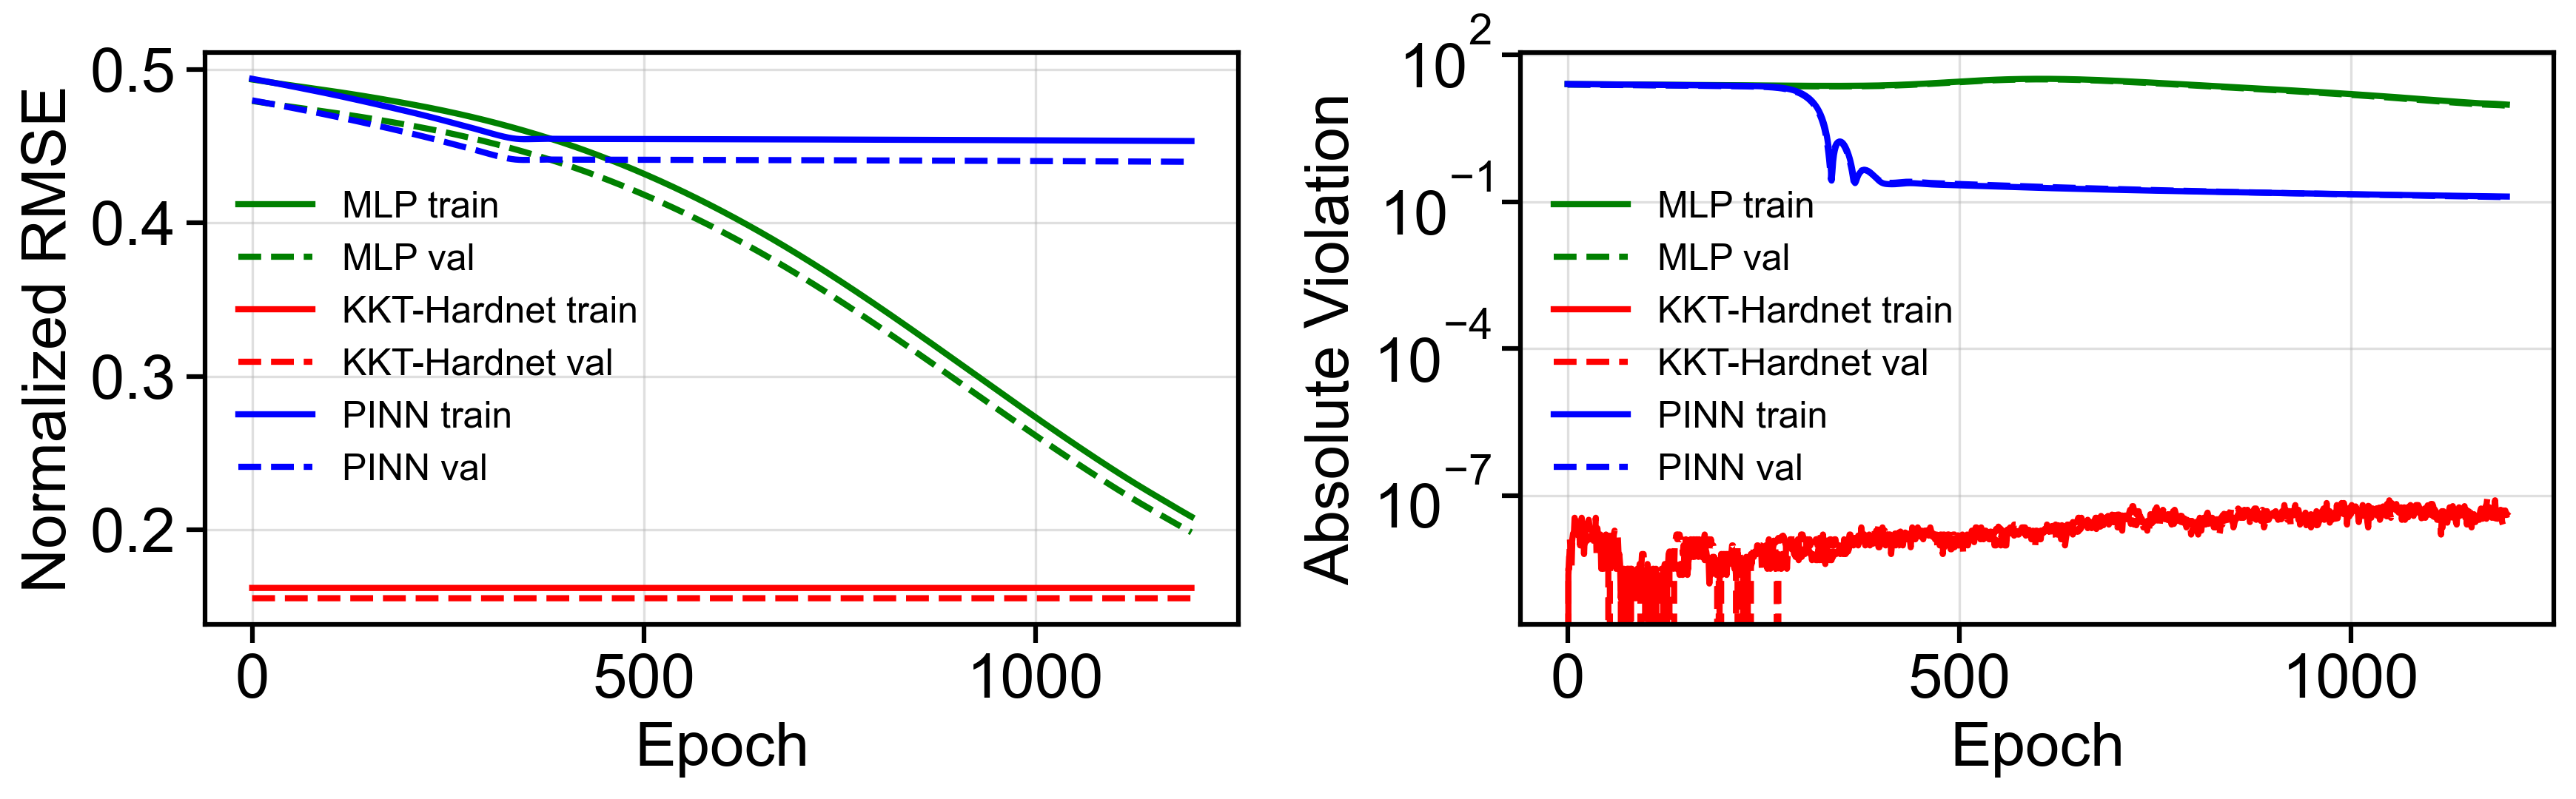

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1234)
np.random.seed(1234)

def gen(n):
    x = np.random.uniform(1, 2, (n, 1)).astype(np.float32)
    y1 = 8 * x**3 + 5
    y2 = 2 * x - 1
    return torch.from_numpy(x), torch.from_numpy(np.concatenate([y1, y2], axis=1))

# Data generation
Xtr, Ytr = gen(1200)
Xva, Yva = gen(300)


def c_of(x):
    x4 = torch.log(torch.clamp_min(x, 1e-6))
    x3 = 2 * x4
    x2 = torch.exp(x3)
    x1 = torch.exp(x4)
    return 12*x2 - 6*x1 + 6

# Models
class VanillaMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,64), nn.ReLU(),
            nn.Linear(64,64), nn.ReLU(),
            nn.Linear(64,2)
        )
    def forward(self, x):
        return self.net(x)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,64), nn.ReLU(),
            nn.Linear(64,64), nn.ReLU(),
            nn.Linear(64,2)
        )
    def forward(self, x):
        return self.net(x)

class FullNewtonLayerKKT(nn.Module):
    """
    - Hard projection via 11 x 11 KKT system on [y1…y7, z1…z3, λ], 
    - Armijo backtracking,
    - Tikhonov regularization for ill-conditioning.
    """
    def __init__(self, K=30, tol=1e-10, max_backtrack=10, c=1e-4):
        super().__init__()
        self.K             = K
        self.tol           = tol
        self.max_backtrack = max_backtrack
        self.c             = c

    def forward(self, x, y0):
        device = x.device
        bsz    = x.size(0)

        # initial guesses =  NN output
        y1 = y0[:, :1].clone()
        y2 = y0[:, 1:2].clone()

        # transformations
        y3 = y2**3
        y6 = y2**2
        y5 = torch.log(torch.clamp_min(y2, 1e-6))
        y4 = 3*y5
        y7 = 2*y5
        z1 = torch.exp(y5)
        z2 = torch.exp(y4)
        z3 = torch.exp(y7)

        # initialize dual
        lam = torch.zeros_like(y1)

        # Newton‐KKT iterations
        for _ in range(self.K):
            c_x = c_of(x)

            # 11 residuals
            F1  = y1 - y0[:, :1] + lam
            F2  = y2 - y0[:, 1:2] - 3*lam*y6
            F3  = y7 - 2*y5
            F4  = y6 - z3
            F5  = z3 - torch.exp(y7)
            F6  = y1 - y3 - c_x
            F7  = y4 - 3*y5
            F8  = y2 - z1
            F9  = y3 - z2
            F10 = z1 - torch.exp(y5)
            F11 = z2 - torch.exp(y4)

            F    = torch.cat([F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11], dim=1)
            maxF = F.abs().max()
            if maxF < self.tol:
                break

            # Jacobian [bsz × 11 × 11]
            J = torch.zeros(bsz, 11, 11, device=device)

            # eqn1
            J[:,0,0]  = 1;     J[:,0,10] = 1
            
            # eqn2
            J[:,1,1]  = 1
            J[:,1,5]  = -3 * lam.view(-1)
            J[:,1,10] = -3 * y6.view(-1)
            
            # eqn3
            J[:,2,6]  = 1;     J[:,2,4]  = -2
            
            # eqn4
            J[:,3,5]  = 1;     J[:,3,9]  = -1
            
            # eqn5
            J[:,4,9]  = 1;     J[:,4,6]  = -torch.exp(y7).view(-1)
            
            # eqn6
            J[:,5,0]  = 1;     J[:,5,2]  = -1
            
            # eqn7
            J[:,6,3]  = 1;     J[:,6,4]  = -3
            
            # eqn8
            J[:,7,1]  = 1;     J[:,7,7]  = -1
            
            # eqn9
            J[:,8,2]  = 1;     J[:,8,8]  = -1
            
            # eqn10
            J[:,9,7]  = 1;     J[:,9,4]  = -torch.exp(y5).view(-1)
            
            # eqn11
            J[:,10,8] = 1;     J[:,10,3] = -torch.exp(y4).view(-1)

            # regularized normal equations
            JT        = J.transpose(-2, -1)                         # [B×11×11]
            JTJ       = JT @ J                                      # [B×11×11]
            eps       = 1e-6                                        # Tikhonov small constant
            I         = torch.eye(JTJ.size(-1), device=device)      # [11×11]
            A         = JTJ + eps * I.unsqueeze(0)                  # [B×11×11]
            b         = JT @ (-F.unsqueeze(-1))                     # [B×11×1]
            delta     = torch.linalg.solve(A, b).squeeze(-1)         # [B×11]


            # backtracking Armijo line-search
            alpha = 1.0
            for _bt in range(self.max_backtrack):
                # update
                y1n  = y1  + alpha*delta[:, 0:1]
                y2n  = y2  + alpha*delta[:, 1:2]
                y3n  = y3  + alpha*delta[:, 2:3]
                y4n  = y4  + alpha*delta[:, 3:4]
                y5n  = y5  + alpha*delta[:, 4:5]
                y6n  = y6  + alpha*delta[:, 5:6]
                y7n  = y7  + alpha*delta[:, 6:7]
                z1n  = z1  + alpha*delta[:, 7:8]
                z2n  = z2  + alpha*delta[:, 8:9]
                z3n  = z3  + alpha*delta[:, 9:10]
                lamn = lam + alpha*delta[:,10:11]

                # compute residuals
                F1n  = y1n - y0[:, :1] + lamn
                F2n  = y2n - y0[:, 1:2] - 3*lamn*y6n
                F3n  = y7n - 2*y5n
                F4n  = y6n - z3n
                F5n  = z3n - torch.exp(y7n)
                F6n  = y1n - y3n - c_x
                F7n  = y4n - 3*y5n
                F8n  = y2n - z1n
                F9n  = y3n - z2n
                F10n = z1n - torch.exp(y5n)
                F11n = z2n - torch.exp(y4n)

                Fnew = torch.cat([F1n,F2n,F3n,F4n,F5n,F6n,F7n,F8n,F9n,F10n,F11n], dim=1)
                if Fnew.abs().max() <= (1 - self.c*alpha)*maxF:
                    break
                alpha *= 0.5  # reduce step size

            
            y1,y2,y3,y4,y5,y6,y7 = y1n,y2n,y3n,y4n,y5n,y6n,y7n
            z1,z2,z3,lam       = z1n,z2n,z3n,lamn

        return torch.cat([y1, y2], dim=1)


class ConstrainedNN_KKT(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Linear(1,64), nn.ReLU(),
            nn.Linear(64,64), nn.ReLU(),
            nn.Linear(64,2)
        )
        # Add the KKT projection layer
        self.proj = FullNewtonLayerKKT()

    def forward(self, x):
        y0 = self.base(x)
        return self.proj(x, y0)

# Helpers for Training
def violation_abs(model, X):
    with torch.no_grad():
        Yp = model(X)
        r  = Yp[:,0] - Yp[:,1]**3 - c_of(X).squeeze(1)
        return torch.mean(r.abs()).item()

def mse_mape(Yh, Y):
    mse  = torch.mean((Yh - Y)**2).item()
    mape = torch.mean((Yh - Y).abs()/Y.abs().clamp_min(1e-12)).item()
    return mse, mape

def train_log(model, Xtr, Ytr, Xva, Yva, epochs=1200, lr=1e-4, tag=""):
    opt, mse = optim.Adam(model.parameters(), lr=lr), nn.MSELoss()
    logs = ([],[],[],[])
    for ep in range(1, epochs+1):
        model.train()
        opt.zero_grad()
        Yp = model(Xtr)
        L  = mse(Yp, Ytr)
        L.backward()
        opt.step()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            Lv  = mse(model(Xva), Yva).item()
            vtr = violation_abs(model, Xtr)
            vva = violation_abs(model, Xva)

        logs[0].append(torch.sqrt(L).item())
        logs[1].append(np.sqrt(Lv))
        logs[2].append(vtr)
        logs[3].append(vva)

        if ep==1 or ep%100==0:
            print(f"[{tag}] ep{ep}/{epochs} train={L:.3e} val={Lv:.3e}"
                  f" vio_tr={vtr:.3e} vio_va={vva:.3e}")
    return [np.array(x) for x in logs]

def train_pinn(model, Xtr, Ytr, Xva, Yva,
               epochs=1200, lr=1e-4, lam=100., tag="PINN"):
    opt, mse = optim.Adam(model.parameters(), lr=lr), nn.MSELoss()
    logs = ([],[],[],[])
    for ep in range(1, epochs+1):
        model.train()
        opt.zero_grad()
        Yp = model(Xtr)
        Lm = mse(Yp, Ytr)
        r  = Yp[:,0] - Yp[:,1]**3 - c_of(Xtr).squeeze(1)
        L  = Lm + lam*(r**2).mean()
        L.backward()
        opt.step()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            Yv  = model(Xva)
            Lv  = mse(Yv, Yva).item()
            vtr = r.abs().mean().item()
            rv  = Yv[:,0] - Yv[:,1]**3 - c_of(Xva).squeeze(1)
            vva = rv.abs().mean().item()

        logs[0].append(torch.sqrt(Lm).item())
        logs[1].append(np.sqrt(Lv))
        logs[2].append(vtr)
        logs[3].append(vva)

        if ep==1 or ep%100==0:
            print(f"[{tag}] ep{ep}/{epochs} train={Lm:.3e} val={Lv:.3e}"
                  f" vio_tr={vtr:.3e} vio_va={vva:.3e}")
    return [np.array(x) for x in logs]


# Instantiate models
mlp = VanillaMLP()
kkt = ConstrainedNN_KKT()
pnn = PINN()

rmse_tr_mlp, rmse_va_mlp, vio_tr_mlp, vio_va_mlp = train_log(mlp, Xtr,Ytr, Xva,Yva, tag="MLP")
rmse_tr_kkt, rmse_va_kkt, vio_tr_kkt, vio_va_kkt = train_log(kkt, Xtr,Ytr, Xva,Yva, tag="KKT-Hardnet")
rmse_tr_pnn, rmse_va_pnn, vio_tr_pnn, vio_va_pnn = train_pinn(pnn, Xtr,Ytr, Xva,Yva, tag="PINN")

# Normalize RMSE
Yall = torch.cat([Ytr, Yva], dim=0)
yrange = (Yall.max(0)[0] - Yall.min(0)[0]).max().item()

norm_tr_mlp  = rmse_tr_mlp  / yrange
norm_va_mlp  = rmse_va_mlp  / yrange
norm_tr_kkt  = rmse_tr_kkt  / yrange
norm_va_kkt  = rmse_va_kkt  / yrange
norm_tr_pnn  = rmse_tr_pnn  / yrange
norm_va_pnn  = rmse_va_pnn  / yrange

# Final Metrics
print("\n=== FINAL METRICS ===")
print("model   train-MSE train-MAPE |vio|   || val-MSE val-MAPE |vio|")
for name, net in [("MLP",mlp),("KKT-Hardnet",kkt),("PINN",pnn)]:
    mse_tr, mape_tr = mse_mape(net(Xtr), Ytr)
    mse_va, mape_va = mse_mape(net(Xva), Yva)
    vtr, vva       = violation_abs(net, Xtr), violation_abs(net, Xva)
    print(f"{name:6s}: {mse_tr:8.3e} {mape_tr:8.3e} {vtr:8.2e} || {mse_va:8.3e} {mape_va:8.3e} {vva:8.2e}")


# Plotting
plt.rc("font", family="Arial")
plt.rcParams.update({
    "font.size":20,
    "axes.linewidth":1.5,
    "xtick.major.size":6, "xtick.major.width":1.5,
    "ytick.major.size":6, "ytick.major.width":1.5,
    "legend.frameon":False
})

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4),dpi=300)

# Normalized RMSE
ax1.plot(norm_tr_mlp,  label="MLP train",  linewidth=2, color='g')
ax1.plot(norm_va_mlp,  "--", label="MLP val",    linewidth=2, color='g')
ax1.plot(norm_tr_kkt,  label="KKT-Hardnet train",linewidth=2, color = 'r')
ax1.plot(norm_va_kkt,  "--", label="KKT-Hardnet val",  linewidth=2, color = 'r')
ax1.plot(norm_tr_pnn,  label="PINN train", linewidth=2, color='b')
ax1.plot(norm_va_pnn,  "--", label="PINN val",   linewidth=2, color='b')
ax1.set(xlabel="Epoch", ylabel="Normalized RMSE")
ax1.grid("--", alpha=0.4)
ax1.legend(fontsize=12)

# Violation
ax2.plot(vio_tr_mlp,  label="MLP train",  linewidth=2, color='g')
ax2.plot(vio_va_mlp,  "--", label="MLP val",    linewidth=2, color='g')
ax2.plot(vio_tr_kkt,  label="KKT-Hardnet train",linewidth=2, color = 'r')
ax2.plot(vio_va_kkt,  "--", label="KKT-Hardnet val",  linewidth=2, color = 'r')
ax2.plot(vio_tr_pnn,  label="PINN train", linewidth=2, color='b')
ax2.plot(vio_va_pnn,  "--", label="PINN val",   linewidth=2, color='b')
ax2.set(xlabel="Epoch", ylabel="Absolute Violation")
ax2.set_yscale("log")
ax2.grid("--", alpha=0.4)
ax2.legend(fontsize=12)

plt.tight_layout()
plt.show()